In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-07-25 14:06:56.975949: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [11]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.boston_housing.load_data()

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [14]:
# normalization

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

print(X_train[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


In [7]:
# expand dimension

dim_target = 12

X_train_1D = tf.expand_dims(X_train[:, dim_target], axis=1)
X_test_1D = tf.expand_dims(X_test[:, dim_target], axis=1)
Y_train_1D = tf.expand_dims(Y_train, axis=1)
Y_test_1D = tf.expand_dims(Y_test, axis=1)

print(X_train_1D.shape)
print(X_test_1D.shape)
print(Y_train_1D.shape)
print(Y_test_1D.shape)

(404, 1)
(102, 1)
(404, 1)
(102, 1)


In [9]:
def plot_graph(X, Y, X_hat=None, Y_hat=None, str_title=None):
    fig = plt.figure(figsize=(8, 6))
    
    if str_title is not None:
        plt.title(str_title, fontsize=20, pad=20)
    
    plt.plot(X, Y, ls="none", marker="o")
    
    if X_hat is not None and Y_hat is not None:
        plt.plot(X_hat, Y_hat)
    
    plt.tick_params(axis="both", labelsize=14)

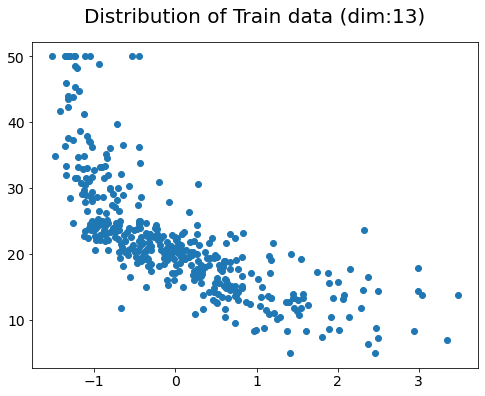

In [13]:
plot_graph(X_train_1D, Y_train_1D, str_title="Distribution of Train data (dim:{})".format(dim_target+1))

## Linear Regression (Closed function)

In [39]:
Xmat_T_Xmat = tf.matmul(tf.transpose(X_train_1D), X_train_1D)    # X^t * X
weight = tf.matmul(
    tf.matmul(tf.linalg.inv(Xmat_T_Xmat), tf.transpose(X_train_1D)),
              Y_train_1D)    # Xw = Y -> w = (X^t * X)^-1 * X^t * Y 

print(weight.shape)
print(weight)

(1, 1)
tf.Tensor([[-6.72258852]], shape=(1, 1), dtype=float64)


In [21]:
loss = tf.math.sqrt(tf.reduce_mean((Y_test - tf.squeeze(tf.matmul(X_test_1D, weight)))**2)).numpy()

print(loss)

23.4293024538165


In [28]:
X_train_for_line = np.expand_dims(np.linspace(np.min(X_train_1D), np.max(X_train_1D), 100), axis=1)
X_test_for_line = np.expand_dims(np.linspace(np.min(X_test_1D), np.max(X_test_1D), 100), axis=1)

In [30]:
print(X_train_1D.shape)
print(X_train_for_line.shape)

(404, 1)
(100, 1)


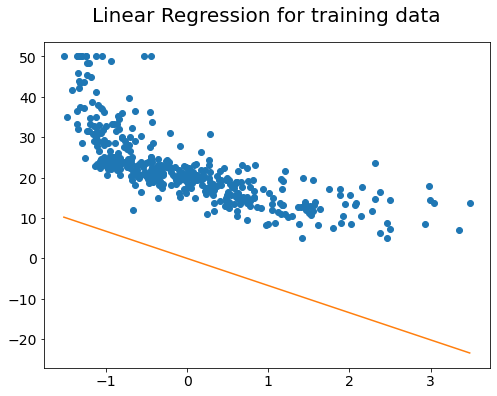

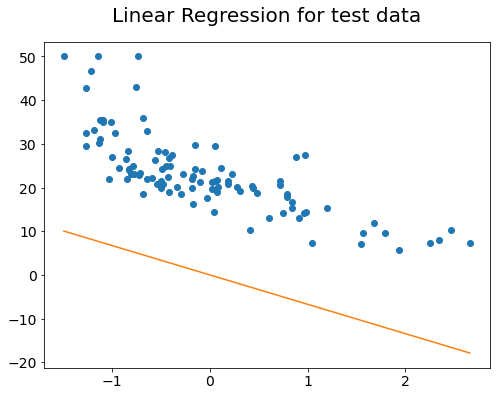

In [40]:
plot_graph(X_train_1D, Y_train,
           X_hat = X_train_for_line,
           Y_hat = tf.matmul(X_train_for_line, weight),
           str_title="Linear Regression for training data")

plot_graph(X_test_1D, Y_test,
           X_hat = X_test_for_line,
           Y_hat = tf.matmul(X_test_for_line, weight),
           str_title="Linear Regression for test data")

In [32]:
def feature_f(X, degree):
    num_X = tf.shape(X)[0]
    Phi = tf.ones([num_X, 1], dtype=tf.dtypes.float64)
    
    for i in range(degree):
        Phi = Phi * X
        if i == degree-1:
            Phi = tf.concat([feature_f(X, degree-1), Phi], axis=1)
    
    return Phi

In [35]:
# φ = [1, x, x^2, x^3]

num_degree = 3

Phi_train = feature_f(X_train_1D, num_degree)
Phi_test = feature_f(X_test_1D, num_degree)

Phi_X_train_for_line = feature_f(X_train_for_line, num_degree)
Phi_X_test_for_line = feature_f(X_test_for_line, num_degree)

Phi_T_Phi = tf.matmul(tf.transpose(Phi_train), Phi_train)    # φ^t * φ
weight_f = tf.matmul(
    tf.matmul(tf.linalg.inv(Phi_T_Phi), tf.transpose(Phi_train)),
              Y_train_1D)    # φw = Y -> w = (φ^t * φ)^-1 * φ^t * Y 

print(weight.shape)
print(weight)

loss = tf.math.sqrt(tf.reduce_mean((Y_test - tf.squeeze(tf.matmul(Phi_test, weight_f)))**2)).numpy()
print(loss)

(4, 1)
tf.Tensor(
[[19.07752281]
 [-7.5439841 ]
 [ 4.02906541]
 [-0.79914931]], shape=(4, 1), dtype=float64)
5.6838884440026085


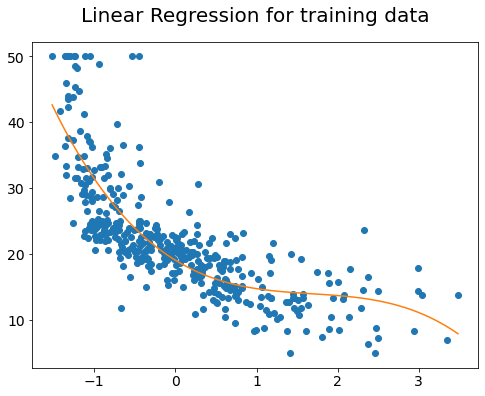

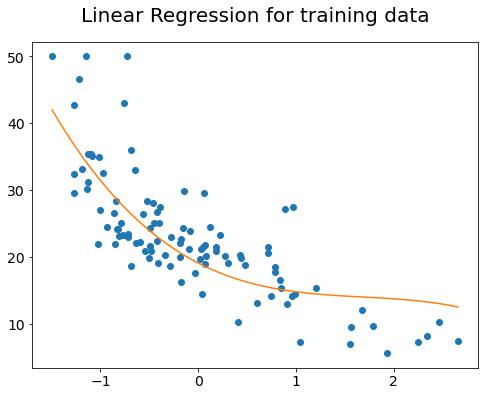

In [41]:
plot_graph(X_train_1D, Y_train,
           X_hat = X_train_for_line,
           Y_hat = tf.matmul(Phi_X_train_for_line, weight_f),
           str_title="Linear Regression for training data")

plot_graph(X_test_1D, Y_test,
           X_hat = X_test_for_line,
           Y_hat = tf.matmul(Phi_X_test_for_line, weight_f),
           str_title="Linear Regression for training data")

## Gradient Descent

In [48]:
(H, W) = weight_f.shape
weight_gd = tf.Variable(np.random.randn(H, W), dtype=tf.dtypes.float64)
weight_gd

<tf.Variable 'Variable:0' shape=(4, 1) dtype=float64, numpy=
array([[-0.08572178],
       [ 1.32063063],
       [ 1.38984693],
       [ 0.65871965]])>

In [51]:
def RMSE(y_pred, y_true):
    return tf.math.sqrt(tf.reduce_mean(tf.square(tf.squeeze(y_pred) - y_true)))

In [53]:
learning_rate = 0.001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

def run_optimization():
    with tf.GradientTape() as gd:
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        
    gradients = gd.gradient(loss, [weight_gd])
    optimizer.apply_gradients(zip(gradients, [weight_gd]))

In [56]:
training_steps = 30000
display_step = 5000

for step in range(1, training_steps + 1):
    run_optimization()
    
    if step % display_step == 0:
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        print("step :", step, ", loss :", loss.numpy(), ", \nweight :\n", weight_gd.numpy())

step :  5000 , loss :  5.90408592206881 , 
weight : 
 [[15.97630953]
 [-5.49136871]
 [ 7.52473443]
 [-2.15599477]]
step :  10000 , loss :  5.7065472547361775 , 
weight : 
 [[16.59021111]
 [-5.85576799]
 [ 6.88057394]
 [-1.91021788]]
step :  15000 , loss :  5.569514408277496 , 
weight : 
 [[17.08342204]
 [-6.16321417]
 [ 6.3318856 ]
 [-1.69982809]]
step :  20000 , loss :  5.476913957636767 , 
weight : 
 [[17.48229898]
 [-6.4210736 ]
 [ 5.87878167]
 [-1.52505749]]
step :  25000 , loss :  5.415583028237912 , 
weight : 
 [[17.80386416]
 [-6.63504645]
 [ 5.51013273]
 [-1.38207327]]
step :  30000 , loss :  5.375534768776722 , 
weight : 
 [[18.06196156]
 [-6.81089125]
 [ 5.21265524]
 [-1.26613597]]


In [58]:
pred = tf.matmul(Phi_test, weight_gd)
loss = RMSE(pred, Y_test).numpy()
print("loss :", loss)

loss : 5.895782076383974


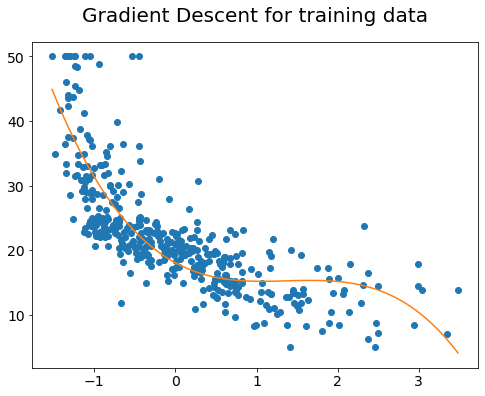

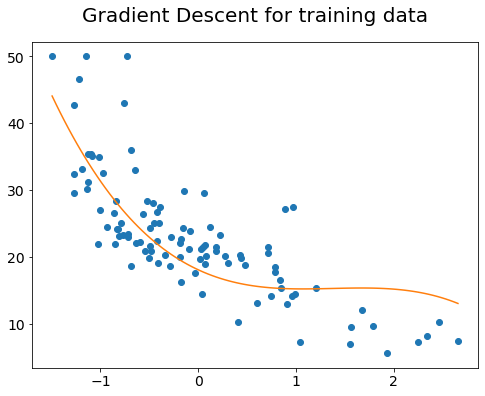

In [59]:
plot_graph(X_train_1D, Y_train,
           X_hat = X_train_for_line,
           Y_hat = tf.matmul(Phi_X_train_for_line, weight_gd),
           str_title="Gradient Descent for training data")

plot_graph(X_test_1D, Y_test,
           X_hat = X_test_for_line,
           Y_hat = tf.matmul(Phi_X_test_for_line, weight_gd),
           str_title="Gradient Descent for training data")

In [73]:
record = tf.constant([[58, 11, 94, 87, 62], [64, 79, 91, 35, 57], [78, 80, 96, 74, 83]], dtype=tf.dtypes.float64)
rate = tf.constant([0.2, 0.3, 0.5], dtype=tf.dtypes.float64)

rate_expand = tf.expand_dims(rate, axis=1)

print(record)
print(rate_expand)
# print(record * rate) # 얘는 broadcasting하기엔 (3, 5)와 (3, )라 차원이 안맞음. 
print(record * rate_expand)
print(tf.multiply(record, rate_expand))
print(tf.math.multiply(record, rate_expand))

tf.Tensor(
[[58. 11. 94. 87. 62.]
 [64. 79. 91. 35. 57.]
 [78. 80. 96. 74. 83.]], shape=(3, 5), dtype=float64)
tf.Tensor(
[[0.2]
 [0.3]
 [0.5]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[11.6  2.2 18.8 17.4 12.4]
 [19.2 23.7 27.3 10.5 17.1]
 [39.  40.  48.  37.  41.5]], shape=(3, 5), dtype=float64)
tf.Tensor(
[[11.6  2.2 18.8 17.4 12.4]
 [19.2 23.7 27.3 10.5 17.1]
 [39.  40.  48.  37.  41.5]], shape=(3, 5), dtype=float64)
tf.Tensor(
[[11.6  2.2 18.8 17.4 12.4]
 [19.2 23.7 27.3 10.5 17.1]
 [39.  40.  48.  37.  41.5]], shape=(3, 5), dtype=float64)
